**Credit card default prediction Using Machine Learning**

ADIB Ahsan(212014006)


**1.Problem Statement**

Financial institutions face significant risks due to customer defaults on credit card payments. Identifying customers who are likely to default in advance is critical for minimizing financial losses and improving credit risk management. However, traditional data processing tools struggle to handle the large-scale and high-dimensional nature of financial transaction datasets.

2.**Project Objectives:**

i. To identify the underlying factors influencing credit card default by performing exploratory data analysis (EDA) on customer demographic, financial, and payment behavior data.

ii. To construct predictive models capable of forecasting whether a customer will default on their credit card payment using machine learning techniques.

iii. To evaluate the performance of the predictive models by measuring accuracy, precision, recall, F1-score, and confusion matrix outcomes.

iv. To compare different machine learning algorithms (e.g., Logistic Regression, Linear Regession) and determine the most effective approach for predicting credit card default.

v. To provide actionable insights and recommendations for financial institutions to minimize default risks and improve customer risk management

**3.Data Minining Goals**

 i. Classification Goal To classify customers into default and non-default categories based on their demographic, financial, and behavioral attributes.

ii. Prediction Goal To develop predictive models that can accurately forecast the likelihood of customer default.

iii. Pattern Discovery Goal To uncover hidden patterns and correlations among variables (e.g., age, payment history, bill amounts) that influence default behavior.

iv. Feature Selection Goal To identify the most significant features contributing to default risk for better model performance and interpretability.

v. Evaluation Goal To assess model effectiveness using accuracy, precision, recall, F1-score, and confusion matrix.

vi. Decision Support Goal To provide actionable insights that help financial institutions make data-driven decisions and reduce financial risks.

4. **Data Understanding**

This project uses the Default of Credit Card Clients Dataset, which consists of 30,000 customer records with demographic, financial, and behavioral information. The dataset contains 23 features

Dataset Link:https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**5.Data Partioning**

In [2]:
!pip install pyspark

In [3]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession


In [4]:
spark = SparkSession.builder\
.appName("ExcelSkipRow")\
.getOrCreate()

In [5]:
file_path = "/content/drive/MyDrive/Classroom/CSE 4460 Big Data Analysis Lab 1/default of credit card clients.xls"

pdf = pd.read_excel(file_path, skiprows=1)

df = spark.createDataFrame(pdf)

df.show(5)

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  1|    20000|  2|        2|       1| 24|    2|    2|   -1|   -1|   -2|   -2|     3913|     3102|      689|        0|        0|        0|       0|     689|       0|       0|       0|       0|                         1|
|  2|   120000|  2|        2|       2| 26|   -1|    2|    0|    0|    0|    2|     2682|     1725|     2682|     3272|  

In [6]:
df_clean = df.dropna()

In [7]:
df_clean = df_clean.dropDuplicates()

In [8]:
from pyspark.sql.functions import col, sum as _sum, when

null_counts = df.select([_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
null_counts.show()

+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
| ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  0|        0|  0|        0|       0|  0|    0|    0|    0|    0|    0|    0|        0|        0|        0|        0|        0|        0|       0|       0|       0|       0|       0|       0|                         0|
+---+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+--

In [9]:
df_clean = df.fillna(0)

In [10]:
print(df.dtypes)

[('ID', 'bigint'), ('LIMIT_BAL', 'bigint'), ('SEX', 'bigint'), ('EDUCATION', 'bigint'), ('MARRIAGE', 'bigint'), ('AGE', 'bigint'), ('PAY_0', 'bigint'), ('PAY_2', 'bigint'), ('PAY_3', 'bigint'), ('PAY_4', 'bigint'), ('PAY_5', 'bigint'), ('PAY_6', 'bigint'), ('BILL_AMT1', 'bigint'), ('BILL_AMT2', 'bigint'), ('BILL_AMT3', 'bigint'), ('BILL_AMT4', 'bigint'), ('BILL_AMT5', 'bigint'), ('BILL_AMT6', 'bigint'), ('PAY_AMT1', 'bigint'), ('PAY_AMT2', 'bigint'), ('PAY_AMT3', 'bigint'), ('PAY_AMT4', 'bigint'), ('PAY_AMT5', 'bigint'), ('PAY_AMT6', 'bigint'), ('default payment next month', 'bigint')]


In [11]:
df_partitioned = df.repartition("MARRIAGE")
print("Partitions:", df_partitioned.rdd.getNumPartitions())
df_partitioned.show()

Partitions: 2
+-----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|   ID|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+-----+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|  219|   110000|  2|        3|       0| 31|    0|    0|    0|    0|    0|    0|    89989|    84229|    79288|    73315|    63818|    63208|    4000|    5000|    3000|    3000|    3000|    8954|                         0|
|  810|   160000|  2|        2|       0| 37|    0|    0|    0|    0|    0|    0|     2694|    3843

In [12]:
df_partitioned = df_partitioned.drop("ID")

df_partitioned.show(5)


+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|LIMIT_BAL|SEX|EDUCATION|MARRIAGE|AGE|PAY_0|PAY_2|PAY_3|PAY_4|PAY_5|PAY_6|BILL_AMT1|BILL_AMT2|BILL_AMT3|BILL_AMT4|BILL_AMT5|BILL_AMT6|PAY_AMT1|PAY_AMT2|PAY_AMT3|PAY_AMT4|PAY_AMT5|PAY_AMT6|default payment next month|
+---------+---+---------+--------+---+-----+-----+-----+-----+-----+-----+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------------------------+
|   110000|  2|        3|       0| 31|    0|    0|    0|    0|    0|    0|    89989|    84229|    79288|    73315|    63818|    63208|    4000|    5000|    3000|    3000|    3000|    8954|                         0|
|   160000|  2|        2|       0| 37|    0|    0|    0|    0|    0|    0|     2694|    38433|    38870|    28574|    27268|    28021|  

**Why I use this Partion technique**?

1.Parallel Processing Distributes data across partitions by SEX, allowing Spark to process Male/Female data in parallel.

2.Faster GroupBy/Aggregation Reduces shuffling when you run queries like groupBy("Marriage").

3.Balanced Workload Ensures data is evenly spread across executors (avoids some partitions being too big/small).

4.Scalability  Makes large datasets easier to handle for analysis and ML tasks.

In [13]:
from pyspark.sql import SparkSession, functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator

In [14]:
for c in df.columns:
    df = df.withColumnRenamed(c, c.strip().replace(' ', '_').replace('(', '').replace(')', ''))

In [15]:
target = None
for c in df.columns:
    if c.lower() in ["default_payment_next_month","default.payment.next.month","default","y"]:
        target = c
        break
if target is None:
    target = df.columns[-1]

In [16]:
print("Rows:", df.count(), " Columns:", len(df.columns))

Rows: 30000  Columns: 25


In [17]:
for cat in ["SEX","EDUCATION","MARRIAGE", "AGE"]:
    if cat in df.columns:
        df.groupBy(cat).agg(F.mean(F.col(target).cast("double")).alias("default_rate")) \
          .orderBy(cat).show()

+---+-------------------+
|SEX|       default_rate|
+---+-------------------+
|  1| 0.2416722745625841|
|  2|0.20776280918727916|
+---+-------------------+

+---------+--------------------+
|EDUCATION|        default_rate|
+---------+--------------------+
|        0|                 0.0|
|        1| 0.19234766178554558|
|        2| 0.23734853884533144|
|        3|  0.2515761643278422|
|        4|0.056910569105691054|
|        5| 0.06428571428571428|
|        6|  0.1568627450980392|
+---------+--------------------+

+--------+-------------------+
|MARRIAGE|       default_rate|
+--------+-------------------+
|       0|0.09259259259259259|
|       1|0.23471703638626545|
|       2|0.20928338762214985|
|       3|0.26006191950464397|
+--------+-------------------+

+---+-------------------+
|AGE|       default_rate|
+---+-------------------+
| 21|  0.208955223880597|
| 22|0.30178571428571427|
| 23| 0.2653061224489796|
| 24|0.26619343389529726|
| 25|0.25463743676222594|
| 26| 0.20143312101910

In [18]:
if "LIMIT_BAL" in df.columns:
    num_cols = [c for c, t in df.dtypes if t in ("int","bigint","double","float") and c!="LIMIT_BAL"]
    for c in num_cols[:15]:
        print(c, "corr with LIMIT_BAL:", df.stat.corr("LIMIT_BAL", c))

ID corr with LIMIT_BAL: 0.02617915774620504
SEX corr with LIMIT_BAL: 0.024755235111644423
EDUCATION corr with LIMIT_BAL: -0.2191606982292125
MARRIAGE corr with LIMIT_BAL: -0.10813941027801291
AGE corr with LIMIT_BAL: 0.14471279755733665
PAY_0 corr with LIMIT_BAL: -0.2712143321347185
PAY_2 corr with LIMIT_BAL: -0.29638210099647994
PAY_3 corr with LIMIT_BAL: -0.2861229539031148
PAY_4 corr with LIMIT_BAL: -0.26746000963939237
PAY_5 corr with LIMIT_BAL: -0.24941139482411043
PAY_6 corr with LIMIT_BAL: -0.23519539948542464
BILL_AMT1 corr with LIMIT_BAL: 0.28542986496498957
BILL_AMT2 corr with LIMIT_BAL: 0.2783143639977607
BILL_AMT3 corr with LIMIT_BAL: 0.28323578358168455
BILL_AMT4 corr with LIMIT_BAL: 0.293987623715988


In [19]:
if "LIMIT_BAL" in df.columns:
    num_cols = [c for c, t in df.dtypes if t in ("int","bigint","double","float") and c!="LIMIT_BAL"]
    for c in num_cols[:15]:
        print(c, "corr with LIMIT_BAL:", df.stat.corr("LIMIT_BAL", c))

ID corr with LIMIT_BAL: 0.02617915774620504
SEX corr with LIMIT_BAL: 0.024755235111644423
EDUCATION corr with LIMIT_BAL: -0.2191606982292125
MARRIAGE corr with LIMIT_BAL: -0.10813941027801291
AGE corr with LIMIT_BAL: 0.14471279755733665
PAY_0 corr with LIMIT_BAL: -0.2712143321347185
PAY_2 corr with LIMIT_BAL: -0.29638210099647994
PAY_3 corr with LIMIT_BAL: -0.2861229539031148
PAY_4 corr with LIMIT_BAL: -0.26746000963939237
PAY_5 corr with LIMIT_BAL: -0.24941139482411043
PAY_6 corr with LIMIT_BAL: -0.23519539948542464
BILL_AMT1 corr with LIMIT_BAL: 0.28542986496498957
BILL_AMT2 corr with LIMIT_BAL: 0.2783143639977607
BILL_AMT3 corr with LIMIT_BAL: 0.28323578358168455
BILL_AMT4 corr with LIMIT_BAL: 0.293987623715988


In [20]:
numeric_cols = ["LIMIT_BAL","AGE","BILL_AMT1", "BILL_AMT2",
                "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4",
                "PAY_AMT5", "PAY_AMT6","SEX", "EDUCATION", "MARRIAGE"]

In [21]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features_raw")
df_vector = assembler.transform(df)

In [22]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
df_sc = scaler.fit(df_vector).transform(df_vector)

print(df_sc.columns)

['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month', 'features_raw', 'features']


In [23]:
df_sc = df_sc.drop("ID")
print(df_sc.columns)



['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month', 'features_raw', 'features']


In [24]:
from pyspark.sql.functions import when, col

total_count = df_sc.count()
count_0 = df_sc.filter(col("default_payment_next_month") == 0).count()
count_1 = df_sc.filter(col("default_payment_next_month") == 1).count()

weight_0 = total_count / (2 * count_0)
weight_1 = total_count / (2 * count_1)

df = df_sc.withColumn("weight", when(col("default_payment_next_month") == 0, weight_0).otherwise(weight_1))

df_0 = df.filter(col("default_payment_next_month") == 0)
df_1 = df.filter(col("default_payment_next_month") == 1)

train_0, test_0 = df_0.randomSplit([0.8, 0.2], seed=42)
train_1, test_1 = df_1.randomSplit([0.8, 0.2], seed=42)

train_df = train_0.union(train_1)
test_df = test_0.union(test_1)

train_df.select("weight", "default_payment_next_month").show(5)
print("Training rows:", train_df.count())
print("Testing rows:", test_df.count())

+------------------+--------------------------+
|            weight|default_payment_next_month|
+------------------+--------------------------+
|0.6420133538777607|                         0|
|0.6420133538777607|                         0|
|0.6420133538777607|                         0|
|0.6420133538777607|                         0|
|0.6420133538777607|                         0|
+------------------+--------------------------+
only showing top 5 rows

Training rows: 24173
Testing rows: 5827


In [25]:
print(df.columns)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment_next_month', 'features_raw', 'features', 'weight']


**SPARK TO PANDAS**

In [53]:
df_pd = df_sc.toPandas()


In [54]:
print(df_pd.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default_payment_next_month', 'features_raw', 'features'],
      dtype='object')


**EXPLORATORY DATA ANALYSIS**

In [55]:

summary_stats = df_pd.describe()
print(summary_stats)


print(df_pd.isnull().sum())


            LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean    167484.322667      1.603733      1.853133      1.551867     35.485500   
std     129747.661567      0.489129      0.790349      0.521970      9.217904   
min      10000.000000      1.000000      0.000000      0.000000     21.000000   
25%      50000.000000      1.000000      1.000000      1.000000     28.000000   
50%     140000.000000      2.000000      2.000000      2.000000     34.000000   
75%     240000.000000      2.000000      2.000000      2.000000     41.000000   
max    1000000.000000      2.000000      6.000000      3.000000     79.000000   

              PAY_0         PAY_2         PAY_3         PAY_4         PAY_5  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      -0.016700     -0.133767     -0.166200     -0.220667     -0.266200   
std        1.123802      1.197186

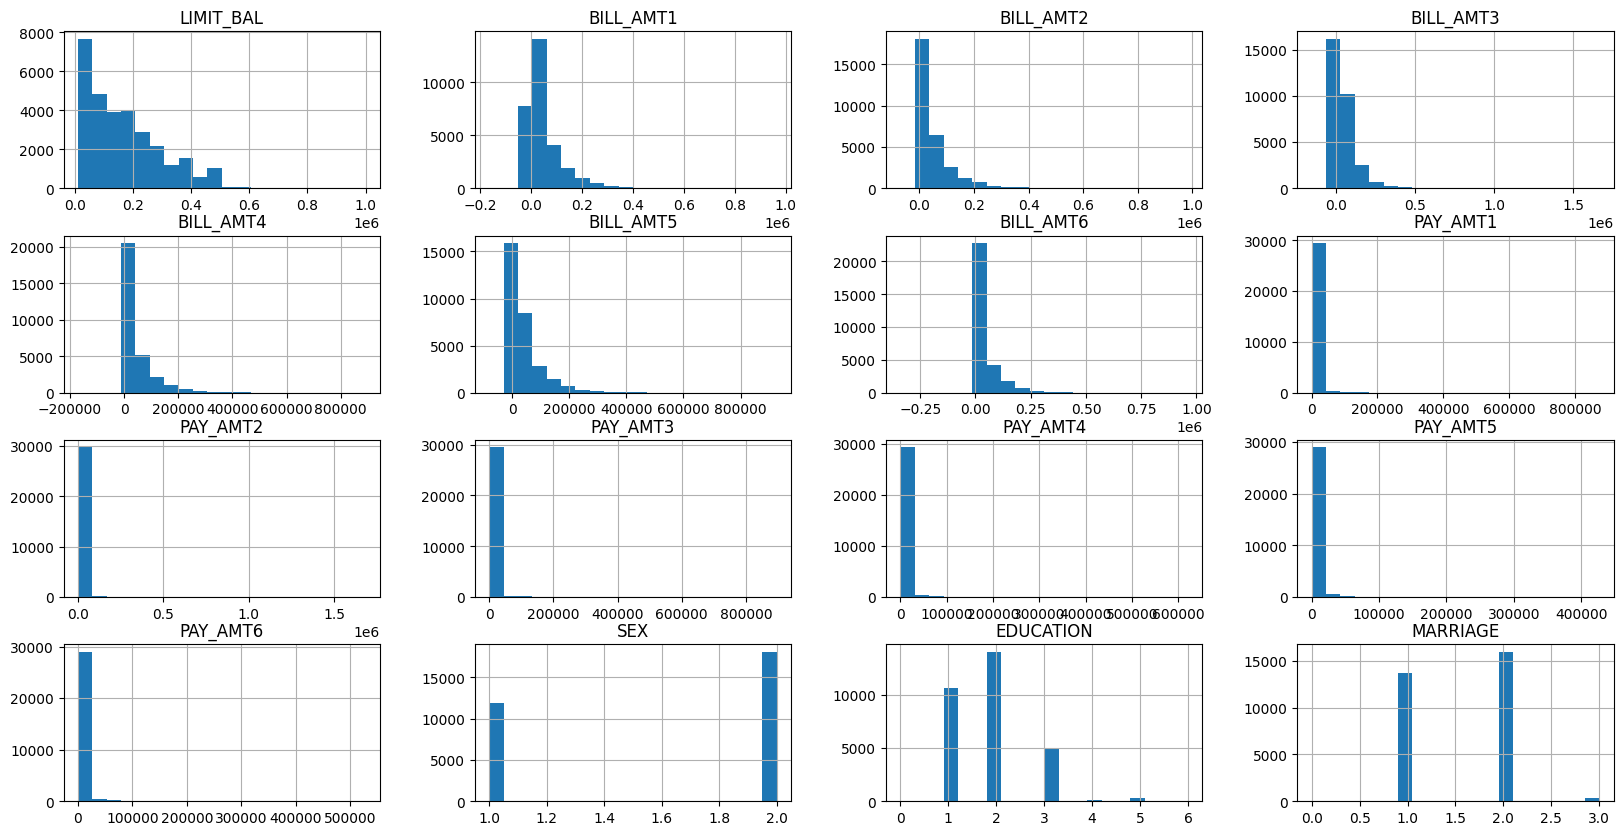

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns


numeric_cols = ["LIMIT_BAL","BILL_AMT1", "BILL_AMT2",
                "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6",
                "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4",
                "PAY_AMT5", "PAY_AMT6","SEX" ,"EDUCATION" ,"MARRIAGE"]

df_pd[numeric_cols].hist(figsize=(20,10), bins=20)
plt.show()


**VISUALIZE**

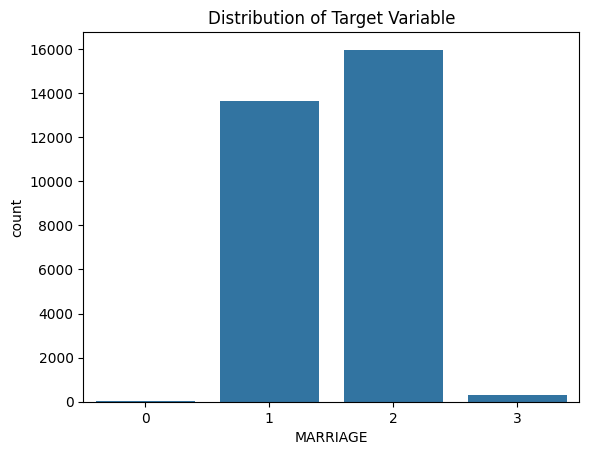

In [57]:
sns.countplot(x="MARRIAGE", data=df_pd)
plt.title("Distribution of Target Variable")
plt.show()



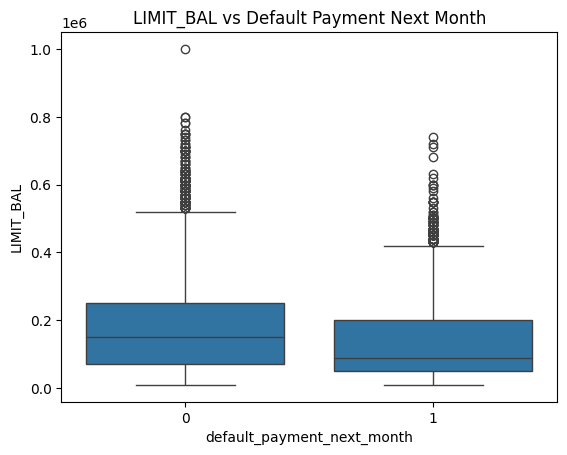

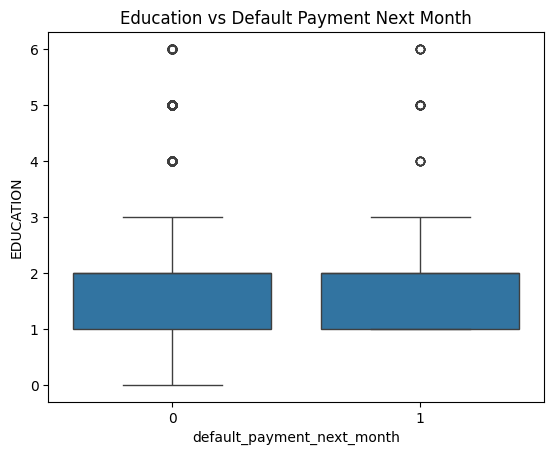

In [58]:
sns.boxplot(x="default_payment_next_month", y="LIMIT_BAL", data=df_pd)
plt.title("LIMIT_BAL vs Default Payment Next Month")
plt.show()

sns.boxplot(x="default_payment_next_month", y="EDUCATION", data=df_pd)
plt.title("Education vs Default Payment Next Month")
plt.show()



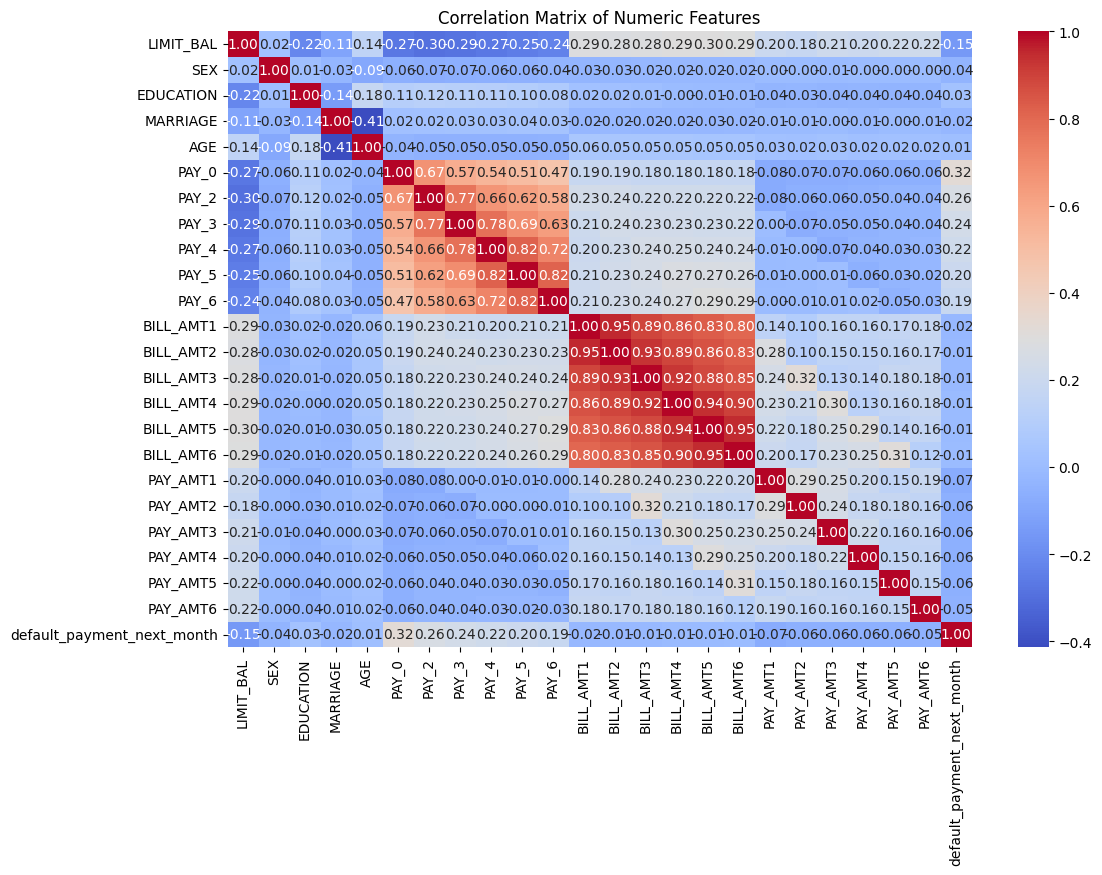

In [60]:
df_corr = df_pd.drop(columns=["features", "features_raw"])
corr = df_corr.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.show()



**FOR IMBALANCE DATSET AND EVALUATION CLASSIFICATION TASK**

In [61]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

df_pd = df.select(numeric_cols + ["default_payment_next_month"]).toPandas()

X = df_pd[numeric_cols]
y = df_pd["default_payment_next_month"]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #smote = SMOTE(random_state=42)
    #X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    random_state=42

    y_pred = model.predict(X_test)

    print(f"\nFold {fold} Results")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    fold += 1




Fold 1 Results
[[3879  793]
 [ 819  509]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4672
           1       0.39      0.38      0.39      1328

    accuracy                           0.73      6000
   macro avg       0.61      0.61      0.61      6000
weighted avg       0.73      0.73      0.73      6000


Fold 2 Results
[[3846  827]
 [ 784  543]]
              precision    recall  f1-score   support

           0       0.83      0.82      0.83      4673
           1       0.40      0.41      0.40      1327

    accuracy                           0.73      6000
   macro avg       0.61      0.62      0.61      6000
weighted avg       0.73      0.73      0.73      6000


Fold 3 Results
[[3898  775]
 [ 799  528]]
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      4673
           1       0.41      0.40      0.40      1327

    accuracy                           0.74      6000

In [119]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
df_pd = df.select(numeric_cols + ["default_payment_next_month"]).toPandas()

X = df_pd[numeric_cols]
y = df_pd["default_payment_next_month"]
dt_model = DecisionTreeClassifier(
    max_depth=5,
    class_weight='balanced',
    random_state=42
)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_train)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_train, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_train, y_pred))

print("Accuracy:", accuracy_score(y_train, y_pred))

=== Confusion Matrix ===
[[14338  4353]
 [ 2413  2896]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.86      0.77      0.81     18691
           1       0.40      0.55      0.46      5309

    accuracy                           0.72     24000
   macro avg       0.63      0.66      0.64     24000
weighted avg       0.75      0.72      0.73     24000

Accuracy: 0.7180833333333333


In [120]:

y_pred_test = dt_model.predict(X_test)

print("=== Test Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_test))

print("\n=== Test Classification Report ===")
print(classification_report(y_test, y_pred_test))

print("Test Accuracy:", accuracy_score(y_test, y_pred_test))


=== Test Confusion Matrix ===
[[3570 1103]
 [ 643  684]]

=== Test Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      4673
           1       0.38      0.52      0.44      1327

    accuracy                           0.71      6000
   macro avg       0.62      0.64      0.62      6000
weighted avg       0.74      0.71      0.72      6000

Test Accuracy: 0.709


In [86]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [87]:
gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [121]:
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

In [122]:
y_pred_train = gb_model.predict(X_train)

print("=== Training Confusion Matrix ===")
print(confusion_matrix(y_train, y_pred_train))

print("\n=== Training Classification Report ===")
print(classification_report(y_train, y_pred_train))

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))

=== Training Confusion Matrix ===
[[18242   449]
 [ 3613  1696]]

=== Training Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.98      0.90     18691
           1       0.79      0.32      0.46      5309

    accuracy                           0.83     24000
   macro avg       0.81      0.65      0.68     24000
weighted avg       0.82      0.83      0.80     24000

Training Accuracy: 0.83075


In [123]:
y_pred_test = gb_model.predict(X_test)

print("\n=== Test Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_test))
print("\n=== Test Classification Report ===")
print(classification_report(y_test, y_pred_test))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))


=== Test Confusion Matrix ===
[[4463  210]
 [1072  255]]

=== Test Classification Report ===
              precision    recall  f1-score   support

           0       0.81      0.96      0.87      4673
           1       0.55      0.19      0.28      1327

    accuracy                           0.79      6000
   macro avg       0.68      0.57      0.58      6000
weighted avg       0.75      0.79      0.74      6000

Test Accuracy: 0.7863333333333333


In [63]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [65]:
print(df_pd.columns)

Index(['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'SEX', 'EDUCATION', 'MARRIAGE',
       'default_payment_next_month'],
      dtype='object')


In [74]:

df_pd = df.select(numeric_cols + ["AGE"]).toPandas()
feature_cols = [c for c in df_pd.columns if c not in ["AGE"]]

X = df_pd[feature_cols]
y = df_pd["AGE"]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (30000, 16)
y shape: (30000,)


In [75]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_reg.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5, random_state=42)

In [76]:
y_pred = dt_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Decision Tree Regression Metrics for Age Prediction")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)


Decision Tree Regression Metrics for Age Prediction
MSE: 0.15563355476037824
MAE: 0.30795038679469616
R2 Score: 0.09647737118739397


In [73]:
y_pred = dt_reg.predict(X_test)


In [77]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

xgb_reg = XGBRegressor(
    max_depth=5,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

In [78]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [79]:
y_pred = xgb_reg.predict(X_test)

In [80]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("XGBoost Regression Metrics for Age Prediction")
print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)

XGBoost Regression Metrics for Age Prediction
MSE: 0.15122251212596893
MAE: 0.29832231998443604
R2 Score: 0.1220853328704834


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,        
    random_state=42
)

In [82]:
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

In [83]:
y_pred_rf = rf_reg.predict(X_test)

In [84]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Metrics for Age Prediction")
print("MSE:", mse_rf)
print("MAE:", mae_rf)
print("R2 Score:", r2_rf)

Random Forest Regression Metrics for Age Prediction
MSE: 0.15358199318734703
MAE: 0.3079844048620985
R2 Score: 0.10838760679494042
